<a href="https://colab.research.google.com/github/kumar045/Assignment-For-Filed/blob/main/YTUBE_013_Form_And_Table_Understanding_LLAVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TABLE and FORM Understanding with LLAVA

In [ ]:
import shutil, os, subprocess
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/YouTube/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/haotian-liu/LLaVA.git@786aa6a19ea10edc6f574ad2e16276974e9aaa3a

  Cloning https://github.com/haotian-liu/LLaVA.git (to revision 786aa6a19ea10edc6f574ad2e16276974e9aaa3a) to /tmp/pip-req-build-92h8ayt9
  Running command git clone --filter=blob:none --quiet https://github.com/haotian-liu/LLaVA.git /tmp/pip-req-build-92h8ayt9
  Running command git rev-parse -q --verify 'sha^786aa6a19ea10edc6f574ad2e16276974e9aaa3a'
  Running command git fetch -q https://github.com/haotian-liu/LLaVA.git 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Resolved https://github.com/haotian-liu/LLaVA.git to commit 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 118.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━

NOW START

['/content/drive/MyDrive/YouTube/imgs/Vision_Form.png', '/content/drive/MyDrive/YouTube/imgs/Vision_Table.png']


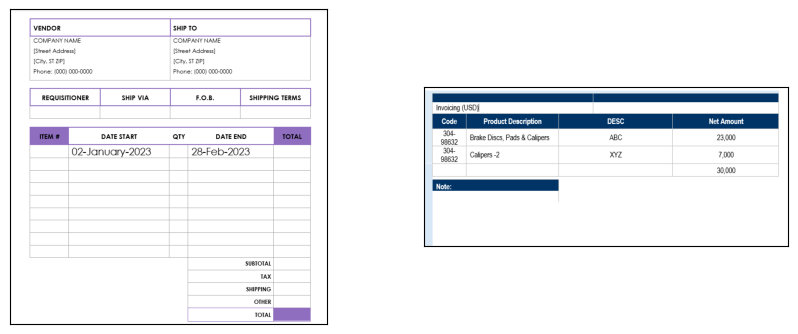

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("/content/drive/MyDrive/YouTube/imgs/"):
    image_paths.append(str(os.path.join("/content/drive/MyDrive/YouTube/imgs/", img_path)))

print(image_paths)
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

In [ ]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
import torch
from PIL import Image
import requests
from io import BytesIO

THANKS TO Gabriele Sgroi

https://towardsdatascience.com/create-your-vision-chat-assistant-with-llava-610b02c3283e

In [ ]:
class LLaVAChatBot:
    def __init__(self,
                 model_path: str = 'liuhaotian/llava-v1.5-7b',
                 device_map: str = 'auto',
                 load_in_8_bit: bool = True,
                 **quant_kwargs) -> None:
        self.model = None
        self.tokenizer = None
        self.image_processor = None
        self.conv = None
        self.conv_img = None
        self.img_tensor = None
        self.roles = None
        self.stop_key = None
        self.load_models(model_path,
                         device_map=device_map,
                         load_in_8_bit=load_in_8_bit,
                         **quant_kwargs)

    def load_models(self, model_path: str,
                    device_map: str,
                    load_in_8_bit: bool,
                    **quant_kwargs) -> None:
        """Load the model, processor and tokenizer."""
        quant_cfg = BitsAndBytesConfig(**quant_kwargs)
        self.model = LlavaLlamaForCausalLM.from_pretrained(model_path,
                                                           low_cpu_mem_usage=True,
                                                           device_map=device_map,
                                                           load_in_8bit=load_in_8_bit,
                                                           quantization_config=quant_cfg)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path,
                                                       use_fast=False)
        vision_tower = self.model.get_vision_tower()
        vision_tower.load_model()
        vision_tower.to(device='cuda')
        self.image_processor = vision_tower.image_processor
        disable_torch_init()

    def setup_image(self, img_path: str) -> None:
        """Load and process the image."""
        if img_path.startswith('http') or img_path.startswith('https'):
            response = requests.get(img_path)
            self.conv_img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            self.conv_img = Image.open(img_path).convert('RGB')
        self.img_tensor = self.image_processor.preprocess(self.conv_img,
                                                          return_tensors='pt'
                                                          )['pixel_values'].half().cuda()

    def generate_answer(self, **kwargs) -> str:
        """Generate an answer from the current conversation."""
        raw_prompt = self.conv.get_prompt()
        input_ids = tokenizer_image_token(raw_prompt,
                                          self.tokenizer,
                                          IMAGE_TOKEN_INDEX,
                                          return_tensors='pt').unsqueeze(0).cuda()
        stopping = KeywordsStoppingCriteria([self.stop_key],
                                            self.tokenizer,
                                            input_ids)
        with torch.inference_mode():
            output_ids = self.model.generate(input_ids,
                                             images=self.img_tensor,
                                             stopping_criteria=[stopping],
                                             **kwargs)
        outputs = self.tokenizer.decode(
            output_ids[0, input_ids.shape[1]:]
        ).strip()
        self.conv.messages[-1][-1] = outputs

        return outputs.rsplit('</s>', 1)[0]

    def get_conv_text(self) -> str:
        """Return full conversation text."""
        return self.conv.get_prompt()

    def start_new_chat(self,
                       img_path: str,
                       prompt: str,
                       do_sample=True,
                       temperature=0.2,
                       max_new_tokens=1024,
                       use_cache=True,
                       **kwargs) -> str:
        """Start a new chat with a new image."""
        conv_mode = "v1"
        self.setup_image(img_path)
        self.conv = conv_templates[conv_mode].copy()
        self.roles = self.conv.roles
        first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                       DEFAULT_IM_END_TOKEN + '\n' + prompt)
        self.conv.append_message(self.roles[0], first_input)
        self.conv.append_message(self.roles[1], None)
        if self.conv.sep_style == SeparatorStyle.TWO:
            self.stop_key = self.conv.sep2
        else:
            self.stop_key = self.conv.sep
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

    def continue_chat(self,
                      prompt: str,
                      do_sample=True,
                      temperature=0.2,
                      max_new_tokens=1024,
                      use_cache=True,
                      **kwargs) -> str:
        """Continue the existing chat."""
        if self.conv is None:
            raise RuntimeError("No existing conversation found. Start a new"
                               "conversation using the `start_new_chat` method.")
        self.conv.append_message(self.roles[0], prompt)
        self.conv.append_message(self.roles[1], None)
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

In [ ]:
chatbot = LLaVAChatBot(load_in_8bit=True,
                       bnb_8bit_compute_dtype=torch.float16,
                       bnb_8bit_use_double_quant=True,
                       bnb_8bit_quant_type='nf8')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
image_path = "imgs/Vision_Form.png"
prompt_text = "what is date start and date end and give output as json with exact values and dont add anything extra "
response = chatbot.start_new_chat(img_path=image_path, prompt=prompt_text)
print(response)

Date Start: 02/01/2022
Date End: 02/28/2023

Output as JSON:
{
"date\_start": "2022-01-02",
"date\_end": "2023-02-28"
}


In [ ]:
image_path = "imgs/Vision_Table.png"
prompt_text = "find out all tables and give output as json "
response = chatbot.start_new_chat(img_path=image_path, prompt=prompt_text)
print(response)

I'm sorry, but I am unable to provide the JSON output as I am a text-based AI assistant and do not have the capability to access or generate JSON files. However, I can provide you with the table data in a tabular format. Please let me know if you need assistance with that.


In [ ]:
image_path = "imgs/Vision_Table.png"
prompt_text = "find out all tables "
response = chatbot.start_new_chat(img_path=image_path, prompt=prompt_text)
print(response)

The image displays a table with several columns, including "Californians," "ABC," and "XYZ." The table is organized with rows and columns, providing a clear structure for the data. The content of the table is not visible, but it is evident that it contains information related to the three columns. The table's purpose could be for data analysis, record-keeping, or any other task that requires organizing and presenting data in a structured manner.


In [ ]:
image_path = "imgs/Vision_Table.png"
prompt_text = "find out table with columns Code and Product Description"
response = chatbot.start_new_chat(img_path=image_path, prompt=prompt_text)
print(response)

I'm sorry, but I cannot provide the specific table you are looking for without more information. Can you please provide more details or context about the table you are referring to?
